In [1]:
import numpy as np
from cvxopt import matrix, solvers, log, exp
import matplotlib.pyplot as plt

from matplotlib import style
import matplotlib
plt.style.use('ggplot')
matplotlib.rcParams.update({"axes.grid" : False})

from PyomoSolver import PyomoSolver

### set up problem

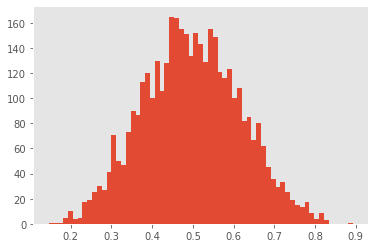

In [2]:
N = 80
M = 50
T = 500

# noise sub-gaussianity parameter
eta = 1
# maximum value of R
max_R = 1

R_true = np.random.beta(8, 8, size=(N, M))

plt.hist(R_true.flatten(), bins=np.int32(np.sqrt(N * M)))
plt.show()
# _, s, _ = np.linalg.svd(R_true)
# plt.yscale("log")
# plt.plot(s)
# plt.show()

### set static capacities

In [3]:
# capacities
C = np.ones(M)
# demands
D = np.ones(N)

### ILP Solver

In [4]:
solver = PyomoSolver(N, M, C, D)

In [5]:
def get_offerings_and_prices(R):
    x = solver.solve_system(R)
    p = solver.get_prices()
    p = p - np.min(p)
    return x, p

In [6]:
def filter_decisions(x, p):
    accepted = np.int32(R_true >= p)
    x_accepted = x * accepted
    # print(np.sum((R_true - p) * x, axis = 0))
    return x_accepted

In [7]:
def get_surplus(x):
    return np.sum(x * R_true)

In [8]:
def get_dissatisfaction(x, p):
    current_surplus = np.sum(x * (R_true - p), axis = 1)
    best_surplus = np.maximum(np.max(R_true - p, axis = 1), 0)
    return np.sum(best_surplus - current_surplus)

In [9]:
def get_proxy(R_lower, R_upper, alpha):
    R_proxy = R_lower + alpha * (R_upper - R_lower)
    return R_proxy

In [10]:
def update_intervals(R_lower, R_upper, p, x_accepted, x_rejected):
    p_extended = np.tile(p,(N, 1))
    R_lower = np.maximum(R_lower, x_accepted * p_extended + (1 - x_accepted) * R_lower)
    R_upper = np.minimum(R_upper, x_rejected * p_extended + (1 - x_rejected) * R_upper)
    return R_lower, R_upper

### get the optimum solution

In [11]:
x_opt, p_opt = get_offerings_and_prices(R_true)
surplus_opt = get_surplus(x_opt)
print(surplus_opt)
print(p_opt)

38.643064948420204
[0.0431996  0.02618232 0.13185342 0.01404526 0.10300523 0.00249305
 0.12313194 0.04336495 0.08486758 0.05332387 0.11538022 0.06985717
 0.06582636 0.04423174 0.08586184 0.14508755 0.07489243 0.1324831
 0.10613653 0.1231863  0.05530721 0.11316181 0.06807094 0.07477207
 0.01892386 0.07534036 0.09389915 0.         0.07217618 0.06526049
 0.0679916  0.07906    0.09730129 0.14121164 0.06428971 0.09317236
 0.06458888 0.06872382 0.07649879 0.07615973 0.12127033 0.05746395
 0.05685477 0.11071951 0.00501003 0.10243961 0.03161089 0.00265569
 0.05173616 0.10218818]


### set the experiment history arrays

In [12]:
exp_names = ["UCB with halving", "UCB with comp pricing"]
num_of_exp = len(exp_names)

rewards = np.zeros((num_of_exp, T))
acceptance = np.zeros((num_of_exp, T))

### UCB with halving

In [13]:
exp_id = 0

delta = 1e-7

R_lower = np.zeros((N, M))
R_upper = max_R * np.ones((N, M))

for t in range(T):
        
    # get a point in each interval
    R_proxy = get_proxy(R_lower, R_upper, 1)
    x_offered, p_w = get_offerings_and_prices(R_proxy)
    
    p_learn = np.max(get_proxy(R_lower, R_upper, 0.5) * x_offered, axis = 0)
        
    R_length = R_upper - R_lower
    to_learn = np.max(x_offered * (R_length > delta), axis = 0) > 0
    p = to_learn * p_learn + (1 - to_learn) * p_w
         
#     p = np.minimum(p_learn, p_w)
    
    x_accepted = filter_decisions(x_offered, p)
    x_rejected = x_offered - x_accepted
    R_lower, R_upper = update_intervals(R_lower, R_upper, p, x_accepted, x_rejected)

    acceptance[exp_id, t] = np.sum(x_accepted) / np.sum(x_offered)
    rewards[exp_id, t] = get_surplus(x_accepted)
    diss = get_dissatisfaction(x_accepted, p)
    
    if t % 10 == 0:
        print(t, rewards[exp_id, t], diss, acceptance[exp_id, t])
        # print(to_learn)
        print(np.linalg.norm(np.sum(R_length * x_offered, axis = 1 )))

        # print(R_length)
        # print(np.linalg.norm(p - p_opt), np.linalg.norm(p_w - p_opt))

print("done")

0 14.23859846886592 18.771403290401118 0.48
7.0710678118654755
10 11.777956510060198 17.559932077223024 0.38
6.224949798994366
20 11.062457552086684 18.071282722012285 0.36
6.254998001598402
30 10.03055125973437 18.21765356385378 0.34
6.284902544988268
40 9.714833427495261 18.104892770525048 0.32
6.041522986797286
50 11.707928927691999 18.70846801854224 0.4
6.519202405202649
60 8.55877804890862 17.94916892099194 0.28
5.916079783099616
70 8.14439563407898 17.90095304435176 0.26
6.0878978309429606
80 11.804648065218178 18.390687723530963 0.4
6.284902544988268
90 8.08341802546111 18.903131085982594 0.26
6.190971248519896
100 10.355619885880394 16.774300808748606 0.32
5.029530201656756
110 12.579658102356891 16.133435908106776 0.38
4.725396449355773
120 15.341946287126571 42.0424536231324 0.42
4.079411916125633
130 15.38911128093356 43.21081614240313 0.44
4.271316518482914
140 15.943651338102873 45.08359175082009 0.44
3.442940031546512
150 19.50803957806665 39.55258893296971 0.52
2.9403258

### UCB with competetive prices

In [14]:
# def find_comp_prices(R_lower, R_upper, x, p):
#     p_extended = np.tile(p,(N, 1))
#     B = R_upper - p_extended
#     A = R_lower - p_extended
#     A_max = np.max(A, axis = 1)
#     A_max_exc = np.max(A * (1 - x), axis = 1)
#     is_valid = (B.T > A_max).T
#     B_min = np.min(B * is_valid + 10 * max_R * (1 - is_valid), axis = 1)
        
#     A_curr = np.sum(A * x, axis = 1)
#     B_curr = np.sum(B * x, axis = 1)
  
#     p_shift = np.zeros(N)
    
#     for n in range(N):
#         if A_max_exc[n] < A_curr[n] and B_min[n] < B_curr[n]:
#             p_shift[n] = B_min[n]
#         else:
#             p_shift[n] = (B_min[n] + A_max[n]) / 2
            
# #     print(np.sum(is_valid))

# #     print(p_shift)
    
#     p = p + x.T @ p_shift
    
        
#     return p

In [15]:
# def find_comp_prices(R_lower, R_upper, x, p, last_accepted_offers):
#     p_extended = np.tile(p,(N, 1))
#     B = R_upper - p_extended
#     A = R_lower - p_extended
#     A_max = np.max(A, axis = 1)
#     offer_next_price = np.sum(last_accepted_offers * x, axis = 1)
    
#     is_valid = (B.T > A_max).T
#     B_min = np.min(B * is_valid + 10 * max_R * (1 - is_valid), axis = 1)
    
#     B_max_exc = np.max(B * (1 - x), axis = 1)
    
#     A_curr = np.sum(A * x, axis = 1)
#     B_curr = np.sum(B * x, axis = 1)
  
#     p_shift = np.zeros(N)
#     for n in range(N):
#         if A_curr[n] >= B_max_exc[n] - 1e-7:
#             p_shift[n] = A_curr[n]
#         elif offer_next_price[n]:
#             p_shift[n] = B_min[n]
#         else:
#             p_shift[n] = (B_min[n] + A_max[n]) / 2
            
#     ratio = (p_shift - A_curr)/(B_curr - A_curr + 1e-12)
#     ratio = np.minimum(np.maximum(ratio, 0.01), 0.99)
#     p_shift = ratio * (B_curr - A_curr) + A_curr
            
# #     print(np.sum(is_valid))

# #     print(p_shift)
        
#     p = p + x.T @ p_shift
    
        
#     return p

In [16]:
def find_comp_prices(R_lower, R_upper, x, p_w):
    p_extended = np.tile(p_w,(N, 1))
    B = R_upper - p_extended
    A = R_lower - p_extended
    A_max = np.max(A, axis = 1)
    
    other_and_valid = (1-x) * (B.T > A_max).T
    B_other_min = np.min(B * other_and_valid + 10 * max_R * (1 - other_and_valid), axis = 1)
    
    B_second_max = np.max(B * (1 - x) - 10 * max_R * x, axis = 1)

    other_best_surplus = np.max((R_upper - p_w) * (1 - x), axis = 1)
    current_worst_surplus = np.sum((R_lower - p_w) * x, axis = 1)
    
    current_best_surplus = np.sum((R_upper - p_w) * x, axis = 1)

    current_R_lower = np.sum(R_lower * x, axis = 1)
    current_R_upper = np.sum(R_upper * x, axis = 1)

    opt_found = np.bitwise_and(current_worst_surplus - other_best_surplus + 1e-8 > 0, current_worst_surplus + 1e-8 > 0)
        
    p_w_user = x @ p_w
    p_user = np.zeros(N)
    for n in range(N):
        if opt_found[n]:
            p_user[n] = p_w_user[n] - 1e-8
        else:
            smallest_price = current_R_lower[n] + 0.3 * (current_R_upper[n] - current_R_lower[n])
            largest_price = current_R_lower[n] + 0.7 * (current_R_upper[n] - current_R_lower[n])
            p_user[n] = p_w_user[n] + A_max[n] + 0.5 * (B_other_min[n] - A_max[n])
            p_user[n] = np.minimum(np.maximum(p_user[n], smallest_price), largest_price)

    print()
    print( x.T @ (p_user - current_R_lower)/( x.T @ (current_R_upper - current_R_lower)))
    
   # print(x.T @ current_R_lower, x.T @ current_R_upper)
    
    p = x.T @ p_user
    
#     print(current_best_surplus - other_best_surplus)
            
#     print(np.sum(opt_found) / len(opt_found))

    # print(p)
        
    return p

In [17]:
exp_id = 1

delta = 1e-7

R_lower = np.zeros((N, M))
R_upper = max_R * np.ones((N, M))

x_accepted = np.zeros((N, M))

for t in range(T):
        
    # get a point in each interval
    R_proxy = get_proxy(R_lower, R_upper, 1)
    x_offered, p_w = get_offerings_and_prices(R_proxy)
        
    p = find_comp_prices(R_lower, R_upper, x_offered, p_w)
        
    x_accepted = filter_decisions(x_offered, p)
    x_rejected = x_offered - x_accepted
    R_lower, R_upper = update_intervals(R_lower, R_upper, p, x_accepted, x_rejected)
    R_length = R_upper - R_lower

    acceptance[exp_id, t] = np.sum(x_accepted) / np.sum(x_offered)
    rewards[exp_id, t] = get_surplus(x_accepted)
    diss = get_dissatisfaction(x_accepted, p)
    
    if t % 10 == 0:
        print(t, rewards[exp_id, t], diss, acceptance[exp_id, t])
        # print(to_learn)
        print(np.linalg.norm(np.sum(R_length * x_offered, axis = 1 )))

        # print(R_length)
        # print(np.linalg.norm(p - p_opt), np.linalg.norm(p_w - p_opt))

print("done")


[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
0 14.23859846886592 18.771403290401118 0.48
3.5355339059327378

[0.7 0.7 0.3 0.7 0.3 0.3 0.7 0.3 0.3 0.3 0.5 0.3 0.3 0.5 0.5 0.3 0.3 0.5
 0.3 0.3 0.5 0.5 0.5 0.5 0.3 0.3 0.3 0.3 0.3 0.3 0.5 0.5 0.5 0.3 0.3 0.5
 0.7 0.3 0.5 0.5 0.7 0.3 0.7 0.3 0.5 0.5 0.5 0.3 0.3 0.5]

[0.6   0.3   0.3   0.4   0.3   0.3   0.5   0.3   0.3   0.625 0.3   0.625
 0.3   0.3   0.4   0.625 0.625 0.4   0.625 0.3   0.3   0.625 0.625 0.4
 0.625 0.4   0.4   0.4   0.4   0.625 0.4   0.625 0.625 0.3   0.3   0.4
 0.625 0.3   0.625 0.625 0.4   0.3   0.6   0.3   0.625 0.625 0.4   0.625
 0.5   0.5  ]

[0.3    0.4    0.575  0.3    0.4    0.575  0.4    0.55   0.5625 0.4
 0.3    0.4    0.5625 0.3    0.3    0.3    0.5625 0.4    0.5625 0.6875
 0.3    0.6875 0.35   0.5625 0.5625 0.3    0.3    0.35   0.3    0.3
 0.6875 0.5625 0


[0.68501465 0.60270508 0.3        0.68451538 0.65857239 0.3
 0.3        0.66289368 0.3        0.68781836 0.3        0.65079346
 0.62573242 0.7        0.66317627 0.65337891 0.7        0.67188873
 0.62500381 0.65737793 0.47704016 0.52973877 0.7        0.7
 0.61621094 0.4640625  0.5626297  0.67683716 0.68493125 0.7
 0.58710083 0.7        0.46787109 0.50001221 0.65248657 0.62501907
 0.53363037 0.51049805 0.3        0.3        0.62794495 0.60698242
 0.67188873 0.65676758 0.7        0.7        0.3        0.51227295
 0.459375   0.61      ]

[0.65995331 0.66259918 0.47216797 0.60250488 0.68438416 0.68500732
 0.68772168 0.3        0.67739688 0.7        0.5        0.44287109
 0.66315063 0.40848633 0.62487793 0.65078735 0.3        0.65004883
 0.48520508 0.67188187 0.3        0.67904358 0.61341797 0.3
 0.62793732 0.67188187 0.7        0.54613525 0.63202148 0.67606506
 0.62501717 0.65735693 0.7        0.62500191 0.53359985 0.50001831
 0.65247375 0.7        0.60661621 0.51037598 0.60378906 0.3
 0.3


[0.7        0.3        0.65733595 0.67901611 0.7        0.62792969
 0.61175998 0.62500003 0.6583185  0.671875   0.67548604 0.7
 0.3        0.54611856 0.56262214 0.60626878 0.3        0.65658844
 0.7        0.3        0.32187802 0.7        0.65860138 0.6467846
 0.7        0.7        0.7        0.62402521 0.663125   0.65078164
 0.66230471 0.67187586 0.684255   0.60230628 0.68762501 0.61567444
 0.7        0.55019531 0.3        0.4875     0.3        0.3
 0.575      0.3        0.675      0.54511719 0.5609375  0.575
 0.575      0.7       ]

[0.62750962 0.7        0.7        0.62792969 0.65733594 0.67901611
 0.671875   0.61175981 0.54611855 0.3        0.60626869 0.65831208
 0.7        0.30378777 0.67548602 0.7        0.47210946 0.56262214
 0.65658839 0.3        0.3        0.3        0.7        0.64528411
 0.6467842  0.7        0.62402526 0.7        0.60230629 0.663125
 0.7        0.65078164 0.687625   0.68425499 0.6623047  0.7
 0.7        0.3        0.54482422 0.3        0.6125     0.6290820


[0.65860508 0.65246095 0.65658834 0.68033175 0.65001892 0.7
 0.7        0.7        0.7        0.56262214 0.7        0.7
 0.60626869 0.60188788 0.54421387 0.30001913 0.5445467  0.6156654
 0.62894585 0.67901611 0.4000494  0.62291809 0.671875   0.55064392
 0.3        0.3        0.63349121 0.55639648 0.3        0.5
 0.3        0.7        0.67174816 0.7        0.7        0.7
 0.6467838  0.63965387 0.7        0.68425498 0.7        0.7
 0.62402521 0.65078164 0.663125   0.7        0.67187586 0.60230628
 0.66230469 0.687625  ]

[0.65001587 0.68033135 0.7        0.7        0.65246095 0.7
 0.65858485 0.7        0.65658834 0.54454641 0.3        0.60188787
 0.3        0.7        0.671875   0.3        0.7        0.3
 0.62287872 0.3        0.7        0.62894558 0.54614972 0.3
 0.63347412 0.55632324 0.58020691 0.57558594 0.57851562 0.60230628
 0.67174816 0.7        0.7        0.7        0.67548602 0.3
 0.7        0.6467838  0.63965379 0.7        0.7        0.62402521
 0.7        0.7        0.65078164


[0.55636607 0.6415625  0.3        0.57740448 0.63346398 0.6500062
 0.55065345 0.7        0.58020619 0.7        0.7        0.7
 0.54454613 0.54614979 0.7        0.53674316 0.7        0.62283936
 0.7        0.5109375  0.50625    0.475      0.3875     0.7
 0.68033095 0.7        0.7        0.65001282 0.7        0.4875
 0.45       0.4        0.4        0.4        0.7        0.6
 0.5        0.7        0.52969538 0.61175969 0.65733594 0.7
 0.7        0.62500003 0.7        0.7        0.7        0.68229165
 0.7        0.7       ]

[0.63890625 0.3        0.62283936 0.65000615 0.7        0.57740444
 0.7        0.63346398 0.7        0.58020619 0.62894531 0.7
 0.3        0.55065345 0.7        0.3        0.54614979 0.7
 0.51171875 0.509375   0.4625     0.49375    0.68033095 0.65001282
 0.7        0.3        0.3        0.7        0.7        0.7
 0.45       0.45       0.3        0.55       0.7        0.3
 0.6        0.61175969 0.5        0.52969538 0.3        0.7
 0.7        0.65733594 0.7        0.7


[   0.7           0.52779053 -294.53150064    0.3          -5.43399865
    0.3           0.3           0.49403076    0.52401047    0.45539793
   -8.28038144    0.66261719    0.3           0.3           0.62283936
    0.44105346    0.7           0.6500061    -8.88435385    0.5
    0.7           0.7           0.7           0.32993197    0.6728125
 -229.24921133    0.47207031    0.7           0.62228669    0.68303164
    0.7           0.68545742    0.58020619  -32.82751291    0.7
    0.7           0.55636606    0.7          -6.39564484    0.55039605
 -134.51760472   -6.27042391    0.45407767 -123.67906223    0.51177483
    0.3           0.63899055    0.7           0.67124322    0.3       ]

[   0.52779907    0.3        -294.53150064    0.52399956   -5.43399865
    0.49404907  -18.4400263     0.62224293    0.7           0.66326172
   -8.28038144    0.7           0.65000076    0.6389912     0.68266824
    0.57740445    0.55636606    0.7           0.3           0.54285162
    0.7           


[ 6.69266641e-01  3.00000000e-01  6.72880840e-01  7.00000000e-01
 -7.91178811e+00  6.15555602e-01  3.00000000e-01  3.33347549e-01
 -3.43212992e+02  7.00000000e-01  3.00000000e-01  3.00000000e-01
  3.00000000e-01  7.00000000e-01  7.00000000e-01  6.70085627e-01
  7.00000000e-01  3.00000000e-01  7.00000000e-01  7.00000000e-01
 -5.72221427e+01  5.50355847e-01  5.84048866e-01  7.00000000e-01
  3.00000000e-01 -1.42590378e+04 -5.77683975e+01  7.00000000e-01
  3.73625364e-01  5.25950561e-01  6.99130718e-01  7.00000000e-01
  7.00000000e-01  7.00000000e-01  7.00000000e-01  3.00000000e-01
  7.00000000e-01  3.00000000e-01 -9.21108981e+00  7.00000000e-01
 -1.29601161e+02 -2.02937132e+01  7.00000000e-01 -9.55453940e+02
  3.00000000e-01  3.00000000e-01  3.00000000e-01  5.17847421e-01
 -2.06808439e+02  5.34441354e-01]
90 16.10299392679741 44.458197454134904 0.42
2.872639734969567

[ 3.00000000e-01  4.30485893e-01  3.00000000e-01  6.05515729e-01
 -7.78501173e+00  4.57798268e-01  3.00000000e-01  5.5035


[-1.95641238e+01 -4.00147817e+02  7.00000000e-01 -4.20241962e+01
  3.00000000e-01  7.00000000e-01 -7.08473160e+03  3.00000000e-01
  6.79078331e-01  3.00000000e-01 -9.33286174e+02 -1.36198279e+02
  3.00000000e-01  7.00000000e-01  7.00000000e-01  7.00000000e-01
  7.00000000e-01 -1.87363570e+03  7.00000000e-01 -6.68677673e+04
  7.00000000e-01  3.00000000e-01  3.00000000e-01  7.00000000e-01
 -1.71950665e+01  7.00000000e-01  6.59756242e-01 -8.01227916e+01
  7.00000000e-01 -4.63057676e+02  7.00000000e-01  3.00000000e-01
  4.81199586e-01  3.00000000e-01 -1.09519706e+02  7.00000000e-01
  7.00000000e-01  6.94095486e-01  3.00000000e-01  3.00000000e-01
 -1.17983849e+02  7.00000000e-01  7.00000000e-01  7.00000000e-01
 -5.37327196e+00 -1.42100203e+02  7.00000000e-01  7.00000000e-01
  7.00000000e-01 -3.84582489e+01]

[-1.95641238e+01 -3.98361987e+02  7.00000000e-01 -4.23768994e+01
 -5.31329570e+01  7.00000000e-01  5.00000000e-01  3.00000000e-01
  5.92513847e-01  3.00000000e-01 -9.31911511e+02  3.00


[-2.83773197e+01 -3.98361987e+02 -4.07495446e+03 -1.71507598e+02
 -5.13784741e+01  7.00000000e-01  7.00000000e-01  5.00000000e-01
  5.00000000e-01 -3.17385668e+01  5.00000000e-01  5.00000000e-01
  4.29897126e-01 -3.28153877e+02  7.00000000e-01  3.00000000e-01
  3.00000000e-01  6.58526597e-01  5.00000000e-01  7.00000000e-01
  6.60162629e-01  5.06924662e-01  7.00000000e-01  6.91648293e-01
 -1.71950665e+01  7.00000000e-01 -1.77959520e+02 -8.01227916e+01
  5.00000000e-01  5.16942921e-01  7.00000000e-01  7.00000000e-01
  6.39071729e-01  3.30459580e-01  7.00000000e-01 -6.01177621e+01
  3.00000000e-01  3.00000000e-01  7.00000000e-01  7.00000000e-01
 -4.86384336e+02  7.00000000e-01  7.00000000e-01  7.00000000e-01
 -5.37327196e+00  7.00000000e-01 -1.84826320e+02  7.00000000e-01
  6.40974068e-01  5.10739281e-01]

[-2.83773197e+01  5.00000000e-01 -4.03908307e+03 -1.71507598e+02
 -5.05794751e+01  7.00000000e-01  7.00000000e-01  5.00000000e-01
  7.00000000e-01 -3.17385668e+01  7.00000000e-01  4.58


[-6.06627981e+02  5.00000000e-01  7.00000000e-01 -1.67602066e+02
  7.00000000e-01  7.00000000e-01  3.00000000e-01  5.00000000e-01
 -3.31001224e+05 -4.46627952e+01  7.00000000e-01  3.22207280e-01
  7.00000000e-01  7.00000000e-01  7.00000000e-01  3.00000000e-01
 -4.29810476e+03 -1.43227382e+04  7.00000000e-01  7.00000000e-01
 -7.50117134e+01 -1.26244914e+02  4.49247411e-01  7.00000000e-01
 -2.45609839e+01  7.00000000e-01 -3.48065281e+02  7.00000000e-01
  5.00000000e-01 -4.63403746e+02  6.32411222e-01  3.00000000e-01
  7.00000000e-01 -1.44337493e+03  7.00000000e-01  5.00000000e-01
  7.00000000e-01  5.00000000e-01 -6.91007935e+02  3.00000000e-01
  7.00000000e-01 -1.62599326e+02  5.00000000e-01  5.00000000e-01
  5.00000000e-01  7.00000000e-01 -1.80521168e+02  3.00000000e-01
  3.00000000e-01  3.00000000e-01]

[ 5.00000000e-01  5.00000000e-01  5.66177080e-01 -1.68600637e+02
  7.00000000e-01  3.96614848e-01 -1.39213775e+04 -4.94249136e+05
  7.00000000e-01 -4.49457286e+01  7.00000000e-01  5.00


[-1.20469164e+03 -4.98880467e+04  7.00000000e-01 -3.28044499e+02
 -7.06870941e+01  3.00000000e-01  5.00000000e-01  5.00000000e-01
 -6.47301131e+05  3.00000000e-01  7.00000000e-01 -7.36095999e+05
 -1.01379887e+03  5.00000000e-01  7.00000000e-01 -2.67276246e+02
 -4.25132491e+03  3.00000000e-01 -3.00508258e+04 -1.04883061e+06
 -7.41966280e+01 -1.00120247e+03 -2.22567865e+04  5.00000000e-01
 -2.41594144e+01 -4.05753770e+05  3.00000000e-01  7.00000000e-01
 -9.08254388e+02 -1.48617511e+04  7.00000000e-01 -3.39128920e+05
 -6.08829572e+03 -1.42770962e+03 -4.60833119e+03 -2.14130024e+02
  3.00000000e-01 -4.64137393e+03 -2.82363752e+03  5.00000000e-01
  5.00000000e-01 -1.55083724e+02  5.00000000e-01  5.00000000e-01
  5.00000000e-01 -3.95060699e+03 -3.27011077e+03  3.66423244e-01
 -2.88259621e+05  7.00000000e-01]

[-1.20323211e+03 -4.98298922e+04 -3.89754378e+03  3.00000000e-01
 -6.99435205e+01  7.00000000e-01 -5.49316294e+04  5.00000000e-01
 -6.46814003e+05  3.00000000e-01 -2.92234474e+04 -7.35


[-2.40720771e+03  5.00000001e-01  5.00000000e-01 -1.50746534e+03
  3.80665245e-01  7.00000000e-01  5.00000000e-01 -1.23611552e+08
 -6.46047752e+05 -4.89405010e+02 -2.91509622e+04  5.00000006e-01
 -6.76819298e+03 -1.34326265e+06  3.00000000e-01 -2.65833291e+02
 -4.26379118e+03 -1.01493790e+02 -2.98502203e+04 -1.04206465e+06
 -7.37026293e+01 -1.24006945e+02  5.00000000e-01 -2.53340417e+07
 -2.39400079e+01 -4.03141515e+05  5.00000000e-01  7.00000000e-01
 -9.02663619e+02 -2.98532247e+04  4.99999999e-01 -1.17771664e+05
 -6.05066302e+03 -1.41821534e+03  5.00000000e-01 -2.12686397e+02
  5.00000000e-01 -7.37712483e+04 -2.84680242e+03  5.00000000e-01
  4.99999999e-01 -1.54070055e+02 -1.42419523e+04  4.99999999e-01
 -2.50178132e+04 -3.92408979e+03 -3.25806942e+03  7.00000000e-01
 -4.61267329e+06 -5.61203208e+03]

[-2.41090366e+03  5.00000002e-01 -7.74898874e+03 -1.50746534e+03
  5.00000000e-01  6.05347490e-01 -2.04227134e+04 -1.23611552e+08
 -6.47030997e+05  3.00000000e-01 -2.93927288e+04  5.00


[-2.40120840e+03 -1.02860508e+08 -7.75432693e+03 -1.50349860e+03
 -3.87717570e+03  5.00000000e-01  5.00000000e-01 -1.23279362e+08
 -6.46962881e+05  5.00000000e-01 -2.91609147e+04 -9.38153338e+07
 -6.74991293e+03 -1.35244382e+06  4.99999998e-01 -8.83199991e+02
 -6.80383591e+04 -1.45025451e+02 -2.97682765e+04  5.00000000e-01
 -7.35008396e+01  4.99900984e-01 -1.11582358e+08 -1.02842648e+08
 -2.38778286e+01 -4.10004149e+05  5.00000000e-01  3.29905068e-01
 -9.00379890e+02 -2.98627715e+04 -9.87799782e+07  4.99999998e-01
 -6.03397157e+03 -1.41433710e+03  5.00000001e-01 -1.01801323e+03
  5.00000000e-01 -1.47314831e+05 -2.83932118e+03  4.99999989e-01
 -5.97839630e+07 -1.53655990e+02 -1.43056558e+04 -1.12082618e+08
 -2.50463513e+04 -3.91325798e+03 -3.25059246e+03  7.00000000e-01
 -4.60033334e+06 -1.79251512e+05]

[-2.39875004e+03 -1.02701780e+08 -7.73781354e+03 -1.50236244e+03
 -3.87426947e+03  5.00000000e-01  5.00000000e-01 -1.23278000e+08
 -6.46328332e+05  5.00000000e-01 -2.92170592e+04 -9.38


[-2.40042509e+03 -1.03336686e+08 -7.75366022e+03 -1.50337308e+03
 -3.87685462e+03  4.99999974e-01  5.00000000e-01 -1.23268850e+08
 -6.46760696e+05  5.00000000e-01 -2.93502488e+04 -9.38071610e+07
 -6.74933447e+03 -1.35186567e+06 -9.74684477e+07 -8.83122563e+02
 -6.80339879e+04 -2.07589964e+02 -2.97656835e+04 -2.07842783e+06
 -7.34944541e+01 -6.78089283e+03 -1.11575144e+08 -1.03493769e+08
 -3.45281574e+01 -4.09970382e+05  5.00000000e-01  7.00000000e-01
 -9.00307623e+02 -2.98602563e+04 -9.87378501e+07 -1.00282202e+08
 -6.03344338e+03 -1.41421437e+03  5.00000004e-01 -4.05762933e+03
 -8.37351315e+07 -1.47302036e+05 -2.83908444e+03 -1.30637408e+08
 -1.19557760e+08 -3.14597729e+02 -4.57759826e+05 -1.12046382e+08
 -2.50384076e+04 -3.91291521e+03 -3.25031645e+03  3.00000000e-01
 -4.59994286e+06  7.00000000e-01]

[-2.39957160e+03 -1.03336686e+08 -7.75092513e+03 -1.50285812e+03
 -3.87553739e+03 -9.02493805e+07  5.00000000e-01 -1.23225725e+08
 -6.46540392e+05 -1.05749228e+08 -2.93403803e+04 -9.37


[-2.39851398e+03 -1.03336686e+08 -7.73781354e+03 -1.50222001e+03
 -3.87390515e+03 -9.02091873e+07  5.00000002e-01 -1.22767792e+08
 -6.46267400e+05 -1.05702405e+08 -2.89659934e+04 -9.34176020e+07
 -6.74402076e+03  4.99999999e-01 -9.73790720e+07 -8.82411312e+02
 -8.68538095e+06 -2.07426247e+02 -2.97418638e+04 -2.07682106e+06
 -7.34357971e+01 -6.77543700e+03 -1.11486307e+08 -1.04270649e+08
 -3.44998608e+01 -4.09660205e+05 -9.17033698e+07 -1.90371932e+02
 -8.99643780e+02  5.00000000e-01 -9.86626002e+07 -9.99215650e+07
 -6.02859144e+03 -1.41308703e+03 -1.06167916e+08 -4.05436429e+03
 -8.36698378e+07 -1.47184502e+05 -2.83690977e+03 -1.30532315e+08
 -1.19464380e+08 -1.30710693e+03  5.00000000e-01 -1.11957971e+08
 -2.50190445e+04 -3.90976658e+03 -3.23722434e+03 -6.95760509e+05
 -4.59635583e+06 -7.17336985e+05]

[-2.39851398e+03 -1.03336686e+08 -7.73781354e+03 -1.50222001e+03
 -3.87390515e+03 -9.02091873e+07  5.00000002e-01 -1.22767792e+08
 -6.46267400e+05 -1.05702405e+08 -2.89659934e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268134e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366926e+02
 -8.99643868e+02  4.99999985e-01 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318755e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34


[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34176120e+07
 -6.74402146e+03 -8.55060163e+07 -9.73790825e+07 -8.82411407e+02
 -8.68538218e+06 -2.07426269e+02 -2.97418669e+04 -2.07682127e+06
 -7.34358049e+01 -6.77543773e+03 -1.11486320e+08 -1.04268132e+08
 -3.44998646e+01 -4.09660247e+05 -9.17033795e+07 -1.90366921e+02
 -8.99643868e+02 -1.22119860e+08 -9.86626102e+07 -9.99215650e+07
 -6.02859209e+03 -1.41308718e+03 -1.06167927e+08 -4.05436472e+03
 -8.36698465e+07 -1.47184518e+05 -2.83691006e+03 -1.30532329e+08
 -1.19464393e+08 -1.30710706e+03 -1.17096550e+08 -1.11957983e+08
 -2.50190471e+04 -3.90976700e+03 -3.23722467e+03 -6.95760509e+05
 -4.59635631e+06 -7.17318737e+05]

[-2.39851423e+03 -1.03336686e+08 -7.73781354e+03 -1.50222016e+03
 -3.87390554e+03 -9.02091970e+07 -8.31971792e+07 -1.22767805e+08
 -6.46267465e+05 -1.05702417e+08 -2.89659964e+04 -9.34

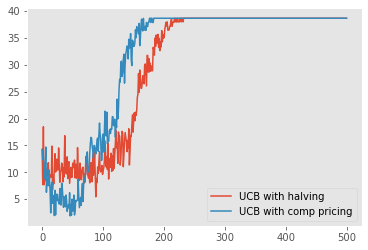

In [18]:
for i in range(num_of_exp):
    plt.plot(np.arange(T), rewards[i], label = exp_names[i])
plt.legend()
plt.show()

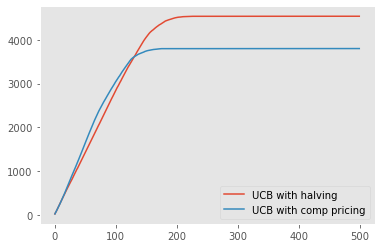

In [19]:
for i in range(num_of_exp):
    plt.plot(np.arange(T), np.cumsum(surplus_opt - rewards[i]), label = exp_names[i])
plt.legend()
plt.show()